<a href="https://colab.research.google.com/github/shivanshu1641/OCR-using-COCO-TEXT/blob/main/Group_1_Text_Recognition_(Colab_3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anuja Somthankar TE COMP B 35

# **Importing Modules**

In [ ]:
import os
import fnmatch
import cv2
import numpy as np
import string
import time
from google.colab import drive

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint


import tensorflow as tf
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt


# Data accessing from Drive

In [ ]:
drive.mount('/content/train')

Mounted at /content/train


## MjSynth data
It is a synthetic dataset, used for Text Recognition.


##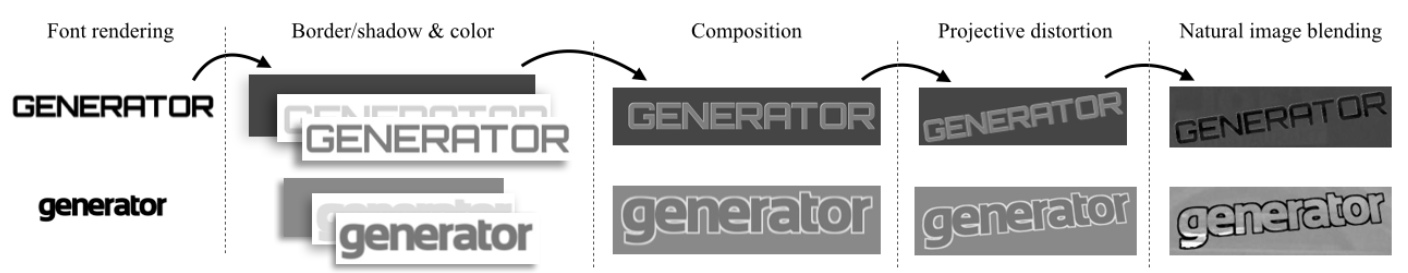

In [ ]:
!unzip "/content/train/My Drive/90kDICT32px.zip" -d "/content/synthText"

Streaming output truncated to the last 5000 lines.
  inflating: /content/synthText/99/3/459_Sleepyheads_71621.jpg  
  inflating: /content/synthText/99/3/45_Paralleling_55435.jpg  
  inflating: /content/synthText/99/3/460_anglo_2859.jpg  
  inflating: /content/synthText/99/3/461_Said_67390.jpg  
  inflating: /content/synthText/99/3/462_melts_47675.jpg  
  inflating: /content/synthText/99/3/463_GALOOTS_31597.jpg  
  inflating: /content/synthText/99/3/464_Shutterbugs_70663.jpg  
  inflating: /content/synthText/99/3/465_UNIMPOSING_82665.jpg  
  inflating: /content/synthText/99/3/466_KASEY_42159.jpg  
  inflating: /content/synthText/99/3/467_SPAY_73154.jpg  
  inflating: /content/synthText/99/3/468_nonspecialists_52166.jpg  
  inflating: /content/synthText/99/3/469_DEPRIVATION_20813.jpg  
  inflating: /content/synthText/99/3/46_BRITTLENESS_9655.jpg  
  inflating: /content/synthText/99/3/470_fronts_31038.jpg  
  inflating: /content/synthText/99/3/471_Semitics_69355.jpg  
  inflating: /conten

In [ ]:
!unzip "/content/train/My Drive/crnn-I.zip"

Archive:  /content/train/My Drive/crnn-I.zip
  inflating: crnn-I.h5               


In [ ]:
drive.flush_and_unmount()

In [ ]:
def getFiles(path):
  return [name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]

In [ ]:
char_list = string.ascii_letters+string.digits
def encode_to_labels(txt):
    res = []
    for index, char in enumerate(txt):
        try:
            res.append(char_list.index(char))
        except:
            print(char)
    return res

# Preparing data for model 





In [ ]:
path = '/content/synthText' 
trainImg = []
trainTxt = []
trainInpLen = []
trainLabelLen = []
trainTrue = []
valImg = []
valTxt = []
valInpLen = []
valLabelLen = []
valTrue = []
testImg = []
testTxt = []
testInpLen = []
testLabelLen = []
testTrue = []
maxLen = 0
i =1 
flag = 0
for root, dirnames, filenames in os.walk(path):
 
    for fname in fnmatch.filter(filenames, '*.jpg'):
        img = cv2.cvtColor(cv2.imread(os.path.join(root, fname)), cv2.COLOR_BGR2GRAY)  
        w, h = img.shape
        if h > 128 or w > 32:
            continue
        if w < 32:
            add_zeros = np.ones((32-w, h))*255
            img = np.concatenate((img, add_zeros))
        if h < 128:
            add_zeros = np.ones((32, 128-h))*255
            img = np.concatenate((img, add_zeros), axis=1)
        img = np.expand_dims(img , axis = 2)
        img = img/255.
        txt = fname.split('_')[1]
        if len(txt) > maxLen:
            maxLen = len(txt)
        if i == 100000:
          break   
        if i%10 == 0:
          if (i%4 == 0):     
            valTrue.append(txt)   
            valLabelLen.append(len(txt))
            valInpLen.append(31)
            valImg.append(img)
            valTxt.append(encode_to_labels(txt))
          else:
            testTrue.append(txt)   
            testLabelLen.append(len(txt))
            testInpLen.append(31)
            testImg.append(img)
            testTxt.append(encode_to_labels(txt))
        else:
            trainTrue.append(txt)   
            trainLabelLen.append(len(txt))
            trainInpLen.append(31)
            trainImg.append(img)
            trainTxt.append(encode_to_labels(txt)) 
        i+=1

In [ ]:
print("Training Images: ",len(trainImg))
print("Validation Images: ",len(valImg))
print("Test Images: ",len(testImg))

Training Images:  90000
Validation Images:  4999
Test Images:  5000


In [ ]:
#Padding the dataframe
trainPadTxt = pad_sequences(trainTxt, maxlen=maxLen, padding='post', value = len(char_list))
valPadTxt = pad_sequences(valTxt, maxlen=maxLen, padding='post', value = len(char_list))
testPadTxt = pad_sequences(testTxt, maxlen=maxLen, padding='post', value = len(char_list))

# Model Building

In [ ]:
inputs = Input(shape=(32,128,1))
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
batch_norm_5 = BatchNormalization()(conv_5)
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)
act_model = Model(inputs, outputs)

## Loss Function

In [ ]:
labels = Input(name='the_labels', shape=[maxLen], dtype='float32')
inputLen = Input(name='input_length', shape=[1], dtype='int64')
labelLen = Input(name='label_length', shape=[1], dtype='int64')
 
 
def ctc_lambda_func(args):
    yPred, labels, inputLen, labelLen = args
 
    return K.ctc_batch_cost(labels, yPred, inputLen, labelLen)
 
 
lossOutput = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, inputLen, labelLen])

#model to be used at training time
model = Model(inputs=[inputs, labels, inputLen, labelLen], outputs=lossOutput)

In [ ]:
model.compile(loss={'ctc': lambda yTrue, yPred: yPred}, optimizer = 'adam')
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]
 

In [ ]:
trainImg = np.array(trainImg)
trainInpLen = np.array(trainInpLen)
trainLabelLen = np.array(trainLabelLen)

valImg = np.array(valImg)
valInpLen = np.array(valInpLen)
valLabelLen = np.array(valLabelLen)

testImg = np.array(testImg)
testInpLen = np.array(testInpLen)
testLabelLen = np.array(testLabelLen)

# Shivanshu Shrivastava TE COMP B 22

# Model Training

In [ ]:
batchSize = 256
epochs = 2
history = model.fit(x=[trainImg, trainPadTxt, trainInpLen, trainLabelLen], y=np.zeros(len(trainImg)), batch_size=batchSize, epochs = epochs, validation_data = ([valImg, valPadTxt, valInpLen, valLabelLen], [np.zeros(len(valImg))]), verbose = 1, callbacks = callbacks_list)

Epoch 1/2
352/352 [==============================] - ETA: 0s - loss: 1.7908
Epoch 00001: val_loss did not improve from 2.69648
352/352 [==============================] - 97s 276ms/step - loss: 1.7908 - val_loss: 2.8108
Epoch 2/2
352/352 [==============================] - ETA: 0s - loss: 1.6071
Epoch 00002: val_loss did not improve from 2.69648
352/352 [==============================] - 96s 274ms/step - loss: 1.6071 - val_loss: 2.7867


In [ ]:
model.save_weights("crnn-I.h5")

In [ ]:
act_model.load_weights("crnn-I.h5")

# Model Testing

In [ ]:
testHistory = model.evaluate(x=[testImg, testPadTxt, testInpLen, testLabelLen], y=np.zeros(len(testImg)))

157/157 [==============================] - 5s 33ms/step - loss: 2.9521


In [ ]:
trainLoss = [27.5, 23.1547, 16.8, 12.47, 8.32, 2.5, 2.23, 1.99]
valLoss = [26.3,16.9, 11.56, 8.45, 3.0019,2.9, 2.7, 2.6]
testLoss = [25.96, 2.89, 2.87, 2.9521]

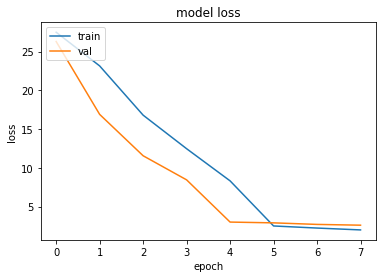

In [ ]:
#Plot Loss
plt.plot(trainLoss)
plt.plot(valLoss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

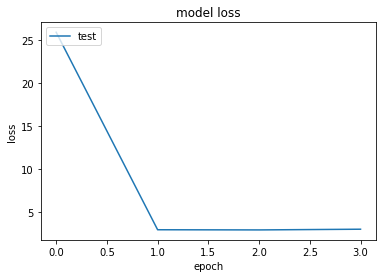

In [ ]:
#Plot Loss
plt.plot(testLoss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['test'], loc='upper left')
plt.show()

In [ ]:
def showImg(fname):
  img = cv2.imread(os.path.join("/content/synthText/1/1", fname))
  #print(img.shape)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
  plt.figure()
  plt.imshow(img)  

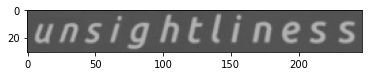

In [ ]:
showImg(valFiles[0])

In [ ]:
def recognizeText(fname):
  img = cv2.imread(fname)
  showImg(fname)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  w,h = img.shape
  print(img.shape)
  if (w>32 and h>128):
    img = cv2.resize(img,(128,32))
    print(1)
  if (w<32 and h>128):
    #add_zeros = np.ones((32-w, h))*255
    #img = np.concatenate((img, add_zeros))
    img = cv2.resize(img,(128,32))
    print(2)
  if (w>32 and h<128):
    #add_zeros = np.ones((32, 128-h))*255
    #img = np.concatenate((img, add_zeros), axis=1)
    #img = cv2.resize(img, (32,128))
    #add_zeros = np.ones((32, 128))*255
    #img = np.concatenate((img, add_zeros), axis=1)
    img = cv2.resize(img,(128,32))
    print(3)
  if w < 32 and h<128:
    #add_zeros = np.ones((32-w, 128 - h))*255
    #img = np.concatenate((img, add_zeros))
    img = cv2.resize(img,(128,32))
    print(4)
  img = np.expand_dims(img , axis = 2) 
  img = np.expand_dims(img , axis = 0)     
  img = img/255.
  print(img.shape)
  prediction = act_model.predict([img]) 
  out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
  for p in out[0]:  
        if int(p) != -1:
            print(char_list[int(p)], end = '')

(31, 247)
2
(1, 32, 128, 1)
unsightliness

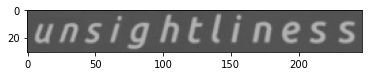

In [ ]:
recognizeText(os.path.join("/content/synthText/1/1", valFiles[0]))

(59, 139)
1
(1, 32, 128, 1)
VEdaNt

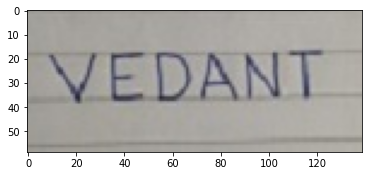

In [ ]:
recognizeText("/content/recognize5.jpeg")

(79, 295)
1
(1, 32, 128, 1)
bilboard

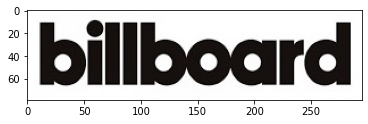

In [ ]:
recognizeText("/content/recognize6.jpg")

(32, 128)
(1, 32, 128, 1)
MIDDLEBOROUCH

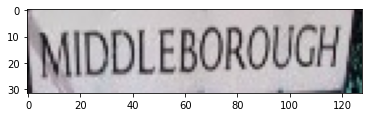

In [ ]:
recognizeText("/content/recognize8.jpg")